# Danish fire insurance data

In [1]:
%run preamble_notebooks.py
danish = pd.read_csv("../Data/Danish/danish.csv").x
from graph_methods import *

## Descriptive statistics

In [2]:
print(danish.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &            x \\
\midrule
count &  2492.000000 \\
mean  &     3.062699 \\
std   &     7.976703 \\
min   &     0.313404 \\
25\%   &     1.157184 \\
50\%   &     1.633858 \\
75\%   &     2.645484 \\
max   &   263.250366 \\
\bottomrule
\end{tabular}



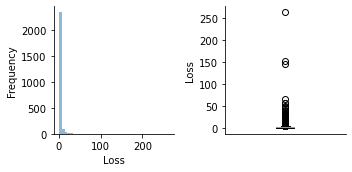

In [3]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(5, 2.5))
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(danish, num_bins, alpha=0.5)
axs[1].boxplot(danish)
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Loss")
axs[1].set_xticks([])
# plt.show()
sns.despine()
plt.savefig("../Figures/hist_boxplot_danish_en.pdf")

## Importation of the fiting data

In [4]:
import pickle
single_model_df_import = pd.read_csv("../Data/Danish/danish_single_model_fit_.csv").drop(columns = ["Unnamed: 0"], axis = 1)
single_model_df_import["threshold_estimation"] = None
single_model_names = single_model_df_import["model"].values
selec = np.logical_or(np.logical_or(single_model_names == "Lognormal-Pareto", single_model_names == "Gamma-Pareto") ,  single_model_names == "Weibull-Pareto")
threshold_estimation = single_model_df_import["threshold_estimation"].values
threshold_estimation[selec] = "simultaneous"
single_model_df_import["threshold_estimation"] =  threshold_estimation
single_model_df_import["Body"] =  None
single_model_df_import["Tail"] =  None
single_model_df_import["Type"] =  None
with open('../Data/Danish/trace_danish_single_models.obj', 'rb') as fp:
    fit_single_dic_import = pickle.load(fp)
spliced_model_fixed_threshold_df_import = pd.read_csv("../Data/Danish/danish_spliced_models_fixed_threshold.csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
spliced_model_fixed_threshold_df_import["threshold_estimation"] = "fixed"
with open('../Data/Danish/trace_danish_spliced_models_fixed_threshold.obj', 'rb') as fp:
    fit_spliced_fixed_threshold_dic_import = pickle.load(fp)
strip_model_names = pd.DataFrame([np.char.split(spliced_model_fixed_threshold_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_fixed_threshold_df_import))])
strip_model_names.columns = ["Body", "Tail", "Type"]
spliced_model_fixed_threshold_df_import = spliced_model_fixed_threshold_df_import.join(strip_model_names)

loss_model_df = pd.concat([single_model_df_import,spliced_model_fixed_threshold_df_import])
fit_loss_model_dic = {**fit_single_dic_import, **fit_spliced_fixed_threshold_dic_import}

loss_models = ["Log-Logistic", "Lomax", "Burr", "Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Inverse-Weibull", "Inverse-Gamma"]

for loss_model in loss_models:
    spliced_model_df_import = pd.read_csv("../Data/Danish/danish_splicing_model_fit_"+loss_model+".csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
    spliced_model_df_import["threshold_estimation"] = "simultaneous"
    strip_model_names = pd.DataFrame([np.char.split(spliced_model_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_df_import))])
    strip_model_names.columns = ["Body", "Tail", "Type"]
    spliced_model_df_import = spliced_model_df_import.join(strip_model_names)

    loss_model_df = pd.concat([loss_model_df, spliced_model_df_import])
    with open("../Data/Danish/trace_danish_"+loss_model+".obj", 'rb') as fp:
        fit_spliced_dic_import = pickle.load(fp)

## Analysis of the composite models with free threshold 

### Goodness of fit comparisons

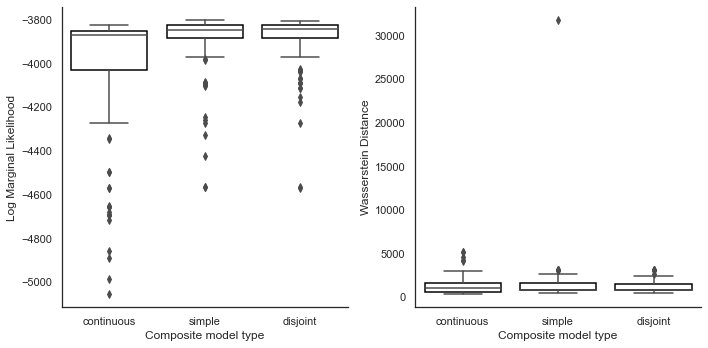

In [5]:
selec = np.logical_and(loss_model_df["Type"].values != None, loss_model_df["threshold_estimation"].values == "simultaneous")  
sub_df = loss_model_df.iloc[selec].reset_index(drop=True)
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))
g = sns.boxplot(ax = axs[0], x="Type", y="log_marg", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Log Marginal Likelihood")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
g = sns.boxplot(ax = axs[1], x="Type", y="Wass_dist", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Wasserstein Distance")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
fig.tight_layout()
sns.despine()
plt.savefig("../Figures/boxplot_danish_log_marg_Wass_free_threshold.pdf")

### Combination of models comparisons

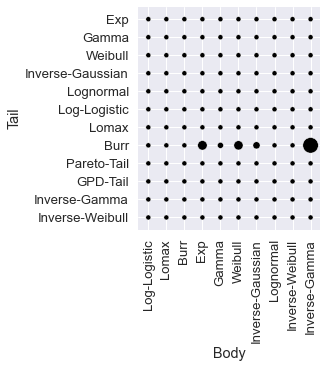

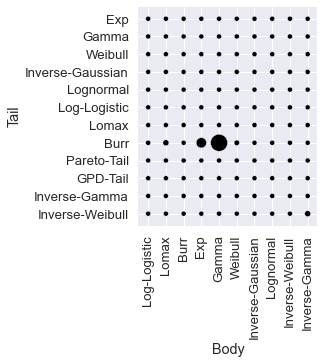

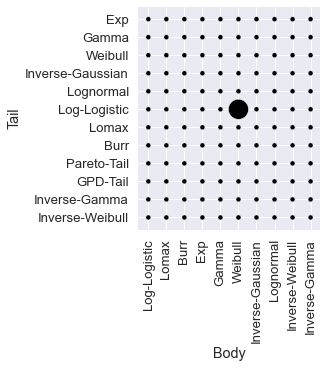

In [6]:
import seaborn as sns
sns.set_theme(style="whitegrid")

compo_model_types = ["disjoint", "simple", "continuous"]
sns.set(font_scale=1.2)
for compo_model_type in compo_model_types:

    s = np.logical_and(loss_model_df["Type"].values == compo_model_type, loss_model_df["threshold_estimation"].values == "simultaneous")  
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    model_grid(sub_df, "log_marg", 0.01, 0.01)
    fig.tight_layout()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_w_"+compo_model_type+"_free_threshold.pdf", bbox_inches='tight')

### Value of the threshold

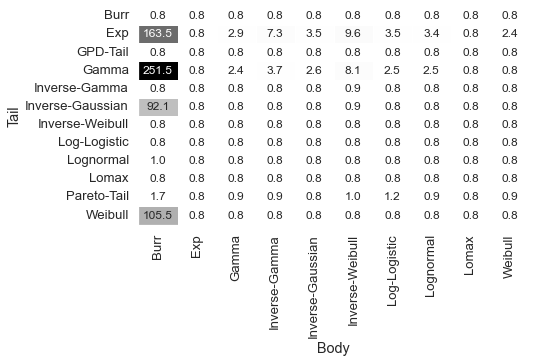

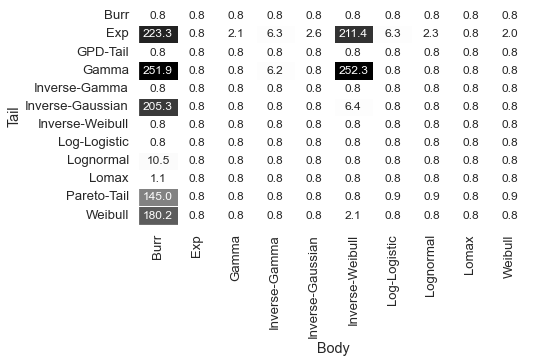

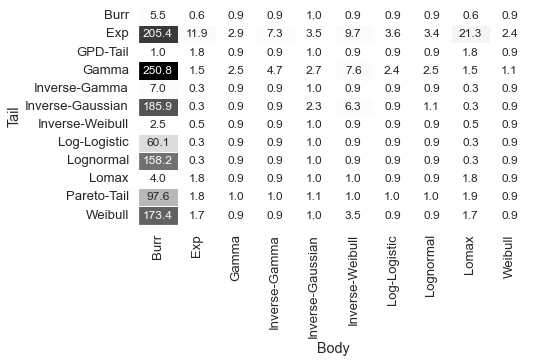

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
sns.set(font_scale=1.2)
pd.options.display.float_format = '{:,.2f}'.format
# Load the example flights dataset and convert to long-form
# flights_long = sns.load_dataset("flights")
compo_model_types = ["disjoint", "simple", "continuous"]
for compo_model_type in compo_model_types:

    s =  np.logical_and(np.logical_and(loss_model_df["threshold_estimation"].values == "simultaneous", loss_model_df["Body"].values != None), loss_model_df["Type"].values == compo_model_type)
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    hm_df = sub_df.pivot("Tail", "Body", "γ_map")
    # hm_df.values
    # # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(7, 4))
    sns.heatmap(hm_df, annot=True, annot_kws={"size": 12}, linewidths=1, fmt='.1f', ax=ax, cmap = "Greys",cbar=False)
    fig.tight_layout()
    sns.despine()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_thresh_"+compo_model_type+"_free_threshold.pdf", bbox_inches='tight')

# Fixed threshold

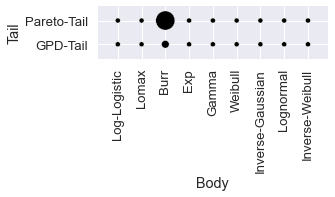

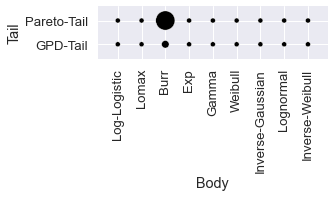

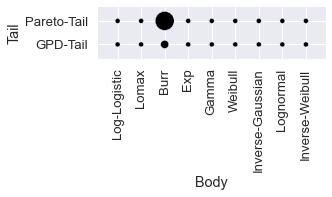

In [10]:
import seaborn as sns
sns.set_theme(style="whitegrid")

compo_model_types = ["disjoint", "simple", "continuous"]
sns.set(font_scale=1.2)
for compo_model_type in compo_model_types:

    s = np.logical_and(loss_model_df["Type"].values == compo_model_type, loss_model_df["threshold_estimation"].values == "fixed")  
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    model_grid(sub_df, "log_marg", 0.05, 0.5)
    fig.tight_layout()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_w_"+compo_model_type+"_fixed_threshold.pdf", bbox_inches='tight')